In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# --- Configuration ---
print(f"TensorFlow Version: {tf.__version__}")

# --- 1. Load Data ---
print("\n--- 1. Loading Data ---")
try:
    file_path = '/content/Dataset.csv'
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully.")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    exit()

# --- 2. Feature Engineering Function ---
def preprocess_and_engineer_features(df):
    """Preprocesses the dataframe and creates new features."""
    for col in ['age', 'gender', 'category']:
        if col in df.columns:
            df[col] = df[col].str.replace("'", "")

    df['amount_log'] = np.log1p(df['amount'])
    customer_avg_amount = df.groupby('customer')['amount_log'].transform('mean')
    df['amount_vs_avg_ratio'] = df['amount_log'] / (customer_avg_amount + 1e-6)

    # NOTE: Time-based features related to 'step' are now removed.
    # df['time_delta_last_txn'] = df.groupby('customer')['step'].diff().fillna(999)

    df['is_new_category'] = (df.groupby(['customer', 'category']).cumcount() == 0).astype(int)
    df['is_new_merchant'] = (df.groupby(['customer', 'merchant']).cumcount() == 0).astype(int)

    categorical_cols = ['age', 'gender', 'merchant', 'category']
    df = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols)

    features_to_drop = ['customer', 'amount', 'zipcodeOri', 'zipMerchant']
    df = df.drop(columns=features_to_drop)
    return df

# --- 3. Preprocessing, Splitting & Scaling ---
print("\n--- 3. Preprocessing, Splitting and Scaling Data ---")
processed_df = preprocess_and_engineer_features(df.copy())

TARGET = 'fraud'
# Dropping 'step' from the final feature set
features_to_drop = ['step', TARGET]
X = processed_df.drop(columns=features_to_drop)
y = processed_df[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print("✅ Data prepped for supervised training.")


# --- 4. Calculate Class Weights & Build Classifier Model ---
print("\n--- 4. Calculating Class Weights & Building Classifier ---")
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(2)}
print(f"Calculated Class Weights: {class_weights}")

input_dim = X_train_scaled.shape[1]
classifier = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_dim,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
classifier.summary()

# --- 5. Train the Supervised Classifier ---
print("\n--- 5. Training Classifier Model ---")
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall',
    patience=5,
    restore_best_weights=True,
    mode='max'
)
history = classifier.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val_scaled, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)
print("✅ Model training complete.")

# --- 6. Final Evaluation ---
print("\n--- 6. Final Performance on Validation Set ---")
y_pred_proba = classifier.predict(X_val_scaled)
y_pred = (y_pred_proba > 0.9485).astype(int)

print(classification_report(y_val, y_pred, target_names=['Legitimate', 'Fraud']))

TensorFlow Version: 2.18.0

--- 1. Loading Data ---
✅ Dataset loaded successfully.

--- 3. Preprocessing, Splitting and Scaling Data ---
✅ Data prepped for supervised training.

--- 4. Calculating Class Weights & Building Classifier ---
Calculated Class Weights: {0: np.float64(0.5061402347333478), 1: np.float64(41.21505583365422)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,865 (81.50 KB)

 Trainable params: 20,865 (81.50 KB)

 Non-trainable params: 0 (0.00 B)


--- 5. Training Classifier Model ---
Epoch 1/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9344 - loss: 0.1266 - precision_1: 0.1811 - recall_1: 0.9759 - val_accuracy: 0.9588 - val_loss: 0.0952 - val_precision_1: 0.2270 - val_recall_1: 0.9961
Epoch 2/50
  42/1673 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9601 - loss: 0.0569 - precision_1: 0.2387 - recall_1: 0.9998

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: accuracy,loss,precision_1,recall_1,val_accuracy,val_loss,val_precision_1,val_recall_1
  current = self.get_monitor_value(logs)


1673/1673 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9668 - loss: 0.0575 - precision_1: 0.2674 - recall_1: 0.9890 - val_accuracy: 0.9727 - val_loss: 0.0672 - val_precision_1: 0.3059 - val_recall_1: 0.9869
Epoch 3/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9698 - loss: 0.0540 - precision_1: 0.2867 - recall_1: 0.9899 - val_accuracy: 0.9753 - val_loss: 0.0638 - val_precision_1: 0.3272 - val_recall_1: 0.9831
Epoch 4/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9744 - loss: 0.0504 - precision_1: 0.3155 - recall_1: 0.9842 - val_accuracy: 0.9721 - val_loss: 0.0689 - val_precision_1: 0.3016 - val_recall_1: 0.9869
Epoch 5/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9735 - loss: 0.0492 - precision_1: 0.3127 - recall_1: 0.9900 - val_accuracy: 0.9670 - val_loss: 0.0700 - val_precision_1: 0.2679 - val_recall_1: 0.9908
Epoch 6/50
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9746 - loss: 0.0494 - precision_1: 0.3206 - recall_1: 0.9876

Getting model predictions...
3345/3345 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Analyzing trade-off...


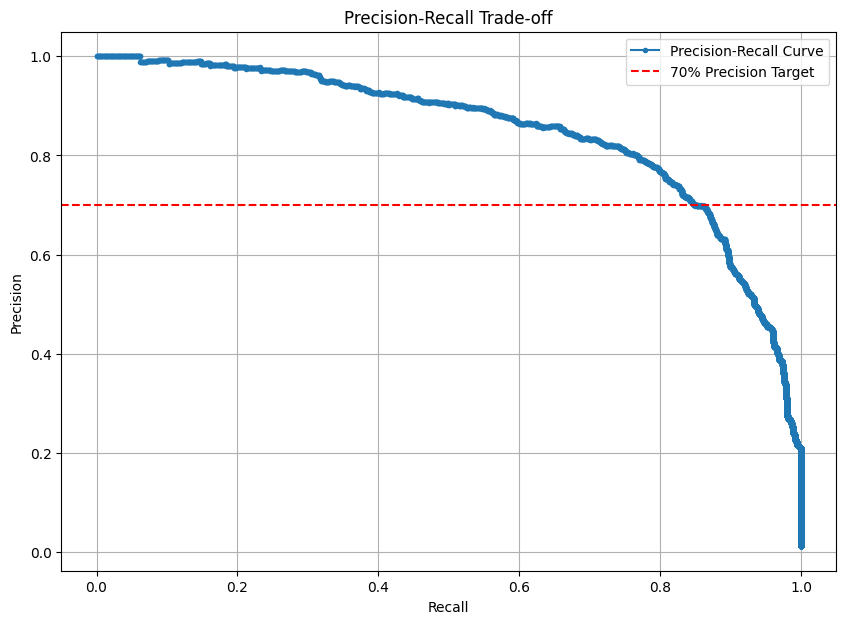


🎯 To achieve ~70% precision, we can use a threshold of: 0.9485

### Report with High-Precision Threshold (0.9485) ###
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    105738
       Fraud       0.70      0.85      0.77      1298

    accuracy                           0.99    107036
   macro avg       0.85      0.92      0.88    107036
weighted avg       0.99      0.99      0.99    107036



In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve

# --- 1. Get Prediction Probabilities (if needed) ---
# This step is very fast.
print("Getting model predictions...")
y_pred_proba = classifier.predict(X_val_scaled).ravel()

# --- 2. Analyze Precision-Recall Trade-off ---
print("Analyzing trade-off...")
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Plotting the curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Trade-off')
plt.axhline(y=0.7, color='r', linestyle='--', label='70% Precision Target')
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Test a New Threshold ---
# Let's find a threshold that gives us a precision of at least 70%
try:
    high_precision_idx = np.where(precision >= 0.70)[0][0]
    new_threshold = thresholds[high_precision_idx - 1]
    print(f"\n🎯 To achieve ~70% precision, we can use a threshold of: {new_threshold:.4f}")

    # Evaluate with this new threshold
    print(f"\n### Report with High-Precision Threshold ({new_threshold:.4f}) ###")
    y_pred_new = (y_pred_proba > new_threshold).astype(int)
    print(classification_report(y_val, y_pred_new, target_names=['Legitimate', 'Fraud']))

except IndexError:
    print("\nCould not find a threshold that achieves 70% precision with this model.")